# 5-4. 영화진흥원 Open API 연동
OpenAPI = 누구나 사용할 수 있도록 공개된 API, 대부분 데이터 교환 형식으로 JSON 사용

> <b>API</b> (Application Programming Interface) : 프로그램에서 데이터를 주고 받기 위한 방법

<span style="color:blue">영화진흥위원회 OpenAPI</span>를 활용하면 현재 극장에서 상영중인 영화들에 대한 박스 오피스 데이터 조회 가능

# #01. 기본 준비 단계
## 1) Key 발급받기
1. 영화진흥위원회 OpenAPI 사이트에 회원가입 후 로그인 수행
2. <b>키 발급/관리</b> 메뉴를 통해 연동에 필요한 인증키 발급

## 2) 연동 스펙 확인하기
http://www.kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do 페이지를 통해 요청에 필요한 정보와 응답형식 확인

## 3) 브라우저를 통한 URL 확인
영화진흥원 OpenAPI 명세서를 통해 요청변수 항목들을 확인, 전체 URL 구성 후 브라우저를 통해 접근
> http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=자신의key값&targetDt=20210301

<b>targetDt</b>값의 경우 하루 전 날짜까지 적용 가능<br>
오늘에 해당하는 값을 전달한 경우 아직 집계되지 않은 데이터이므로 데이터가 조회되지 않음

웹 브라우저를 통해 JSON을 직접 확인하는 경우 JSON 전문이 한 줄로 표시되어 확인이 어려운 부분이 있다.<br>
이 경우 크롬 브라우저를 통해 <b>크롬 웹 스토어</b>에서 <b>JSONVIew</b> 확장 프로그램 설치 후 재접속 시 JSON 데이터를 보기 좋게 정렬/컬러링 적용

## 4) 필요한 패키지 가져오기

In [1]:
import requests
import json
import datetime as dt
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot

## 5) API 키 준비하기

In [2]:
api_key = "498bf1773e4b92ddef9471c8f988acb3"

## 6) 세션 생성

In [3]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36"
session= requests.Session()
session.headers.update({'User-agent':user_agent, 'referer':None})

# #02. 특정 날짜에 대한 박스오피스 관람객 수
영화진흥위원회의 OpenAPI는 오늘을 기준으로 하루 전 날까지의 데이터를 제공한다.

## 1) 접속 주소 준비하기
변수가 치환될 주소 템플릿

In [8]:
url_tpl = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={key}&targetDt={date}'

### 조회날짜 문자열 만들기
여기서는 어제 날짜로 준비함

In [5]:
today = dt.datetime.now()
delta = dt.timedelta(days=-1)                  # 하루 전을 의미하는 timedelta 객체
yesterday = today+delta                        # 오늘 날짜와 timedelta 연산
yesterday_str = yesterday.strftime('%Y%m%d')   # yyyymmdd 형식 문자열로 변환
yesterday_str

'20210301'

### 최종접속 주소 확인

In [9]:
api_url = url_tpl.format(key=api_key, date=yesterday_str)
api_url

'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=498bf1773e4b92ddef9471c8f988acb3&targetDt=20210301'

## 2) API를 통한 JSON 데이터 가져오기
### OpenAPI 통한 JSON 가져오기

In [11]:
# 데이터 가져오기
r = session.get(api_url)

# 결과 검사
if r.status_code != 200:
    print("[%d Error] %s" % (r.status_code, r.reason))
    quit()
    
#인코딩 형식 지정
r.encoding = 'utf-8'

# 텍스트 출력
r.text

'{"boxOfficeResult":{"boxofficeType":"일별 박스오피스","showRange":"20210301~20210301","dailyBoxOfficeList":[{"rnum":"1","rank":"1","rankInten":"2","rankOldAndNew":"OLD","movieCd":"20207443","movieNm":"소울","openDt":"2021-01-20","salesAmt":"329357370","salesShare":"21.6","salesInten":"-9105340","salesChange":"-2.7","salesAcc":"17740397050","audiCnt":"34390","audiInten":"-1300","audiChange":"-3.6","audiAcc":"1915033","scrnCnt":"784","showCnt":"1877"},{"rnum":"2","rank":"2","rankInten":"-1","rankOldAndNew":"OLD","movieCd":"20199541","movieNm":"미션 파서블","openDt":"2021-02-17","salesAmt":"319052630","salesShare":"20.9","salesInten":"-39028330","salesChange":"-10.9","salesAcc":"3309280110","audiCnt":"34099","audiInten":"-4673","audiChange":"-12.1","audiAcc":"365231","scrnCnt":"778","showCnt":"2123"},{"rnum":"3","rank":"3","rankInten":"-1","rankOldAndNew":"OLD","movieCd":"20200703","movieNm":"극장판 귀멸의 칼날: 무한열차편","openDt":"2021-01-27","salesAmt":"322045030","salesShare":"21.1","salesInten":"-35072100","

### JSON을 딕셔너리로 변환

In [12]:
daily_boxoffice_dict = json.loads(r.text)
daily_boxoffice_dict

{'boxOfficeResult': {'boxofficeType': '일별 박스오피스',
  'showRange': '20210301~20210301',
  'dailyBoxOfficeList': [{'rnum': '1',
    'rank': '1',
    'rankInten': '2',
    'rankOldAndNew': 'OLD',
    'movieCd': '20207443',
    'movieNm': '소울',
    'openDt': '2021-01-20',
    'salesAmt': '329357370',
    'salesShare': '21.6',
    'salesInten': '-9105340',
    'salesChange': '-2.7',
    'salesAcc': '17740397050',
    'audiCnt': '34390',
    'audiInten': '-1300',
    'audiChange': '-3.6',
    'audiAcc': '1915033',
    'scrnCnt': '784',
    'showCnt': '1877'},
   {'rnum': '2',
    'rank': '2',
    'rankInten': '-1',
    'rankOldAndNew': 'OLD',
    'movieCd': '20199541',
    'movieNm': '미션 파서블',
    'openDt': '2021-02-17',
    'salesAmt': '319052630',
    'salesShare': '20.9',
    'salesInten': '-39028330',
    'salesChange': '-10.9',
    'salesAcc': '3309280110',
    'audiCnt': '34099',
    'audiInten': '-4673',
    'audiChange': '-12.1',
    'audiAcc': '365231',
    'scrnCnt': '778',
    'sho

### 딕셔너리를 데이터프레임으로 변환

In [13]:
daily_boxoffice_df = DataFrame(daily_boxoffice_dict['boxOfficeResult']['dailyBoxOfficeList'])
daily_boxoffice_df

,rnum,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,salesChange,salesAcc,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt
0,1,1,2,OLD,20207443,소울,2021-01-20,329357370,21.6,-9105340,-2.7,17740397050,34390,-1300,-3.6,1915033,784,1877
1,2,2,-1,OLD,20199541,미션 파서블,2021-02-17,319052630,20.9,-39028330,-10.9,3309280110,34099,-4673,-12.1,365231,778,2123
2,3,3,-1,OLD,20200703,극장판 귀멸의 칼날: 무한열차편,2021-01-27,322045030,21.1,-35072100,-9.8,8885918380,32618,-3144,-8.8,925734,719,1483
3,4,4,1,OLD,20202555,톰과 제리,2021-02-24,195877110,12.9,-18909180,-8.8,963527320,21987,-1729,-7.3,113328,883,2082
4,5,5,-1,OLD,20215843,카오스 워킹,2021-02-24,176612900,11.6,-66526760,-27.4,1000914500,20060,-7272,-26.6,119886,720,2094
5,6,6,0,OLD,20198663,고백,2021-02-24,23464300,1.5,-9713200,-29.3,171153300,2574,-1685,-39.6,23599,238,433
6,7,7,0,OLD,20209013,워 위드 그랜파,2021-02-24,18512060,1.2,-2038420,-9.9,102403290,2068,-301,-12.7,12447,296,397
7,8,8,0,OLD,20214848,퍼펙트 케어,2021-02-19,13561080,0.9,-887280,-6.1,194810080,1458,-134,-8.4,23034,101,113
8,9,9,2,OLD,20215221,더 레이서,2021-02-24,9108340,0.6,-1237550,-12,62355840,1123,-152,-11.9,7593,137,164
9,10,10,0,OLD,20050310,해리 포터와 불의 잔,2005-12-01,11196500,0.7,-2030500,-15.4,22065941900,1088,-202,-15.7,3496023,26,45


## 2) 데이터 전처리
### 사용할 컬럼만 추출

In [14]:
tmp_df = daily_boxoffice_df.filter(['movieNm', 'audiCnt'])
tmp_df

,movieNm,audiCnt
0,소울,34390
1,미션 파서블,34099
2,극장판 귀멸의 칼날: 무한열차편,32618
3,톰과 제리,21987
4,카오스 워킹,20060
5,고백,2574
6,워 위드 그랜파,2068
7,퍼펙트 케어,1458
8,더 레이서,1123
9,해리 포터와 불의 잔,1088


### 컬럼이름 변경

In [17]:
tmp_df2 = tmp_df.rename(columns={'movieNm':'영화제목', 'audiCnt':'관람객'})
tmp_df2

,영화제목,관람객
0,소울,34390
1,미션 파서블,34099
2,극장판 귀멸의 칼날: 무한열차편,32618
3,톰과 제리,21987
4,카오스 워킹,20060
5,고백,2574
6,워 위드 그랜파,2068
7,퍼펙트 케어,1458
8,더 레이서,1123
9,해리 포터와 불의 잔,1088


### 영화제목을 인덱스로 지정

In [18]:
daily_rank_df = tmp_df2.set_index('영화제목')
daily_rank_df

,관람객
영화제목,
소울,34390
미션 파서블,34099
극장판 귀멸의 칼날: 무한열차편,32618
톰과 제리,21987
카오스 워킹,20060
고백,2574
워 위드 그랜파,2068
퍼펙트 케어,1458
더 레이서,1123


### 관람객 컬럼에 대한 데이터 타입 확인
외부에서 수집한 데이터의 경우 숫자 모양을 한 문자열 형식인 경우가 대부분이므로 반드시 분석할 컬럼만 출력하여 type을 확인

> type이 `int`나 `float` 형식이 아닌 경우 타입 변환 처리가 필수적으로 요구

In [19]:
daily_rank_df['관람객']

영화제목
소울                   34390
미션 파서블               34099
극장판 귀멸의 칼날: 무한열차편    32618
톰과 제리                21987
카오스 워킹               20060
고백                    2574
워 위드 그랜파              2068
퍼펙트 케어                1458
더 레이서                 1123
해리 포터와 불의 잔           1088
Name: 관람객, dtype: object

### 관람객 컬럼의 타입을 숫자 형식으로 변환

In [20]:
daily_rank_df['관람객'] = daily_rank_df['관람객'].apply(pd.to_numeric)
daily_rank_df['관람객']

영화제목
소울                   34390
미션 파서블               34099
극장판 귀멸의 칼날: 무한열차편    32618
톰과 제리                21987
카오스 워킹               20060
고백                    2574
워 위드 그랜파              2068
퍼펙트 케어                1458
더 레이서                 1123
해리 포터와 불의 잔           1088
Name: 관람객, dtype: int64

## 3) 데이터 시각화

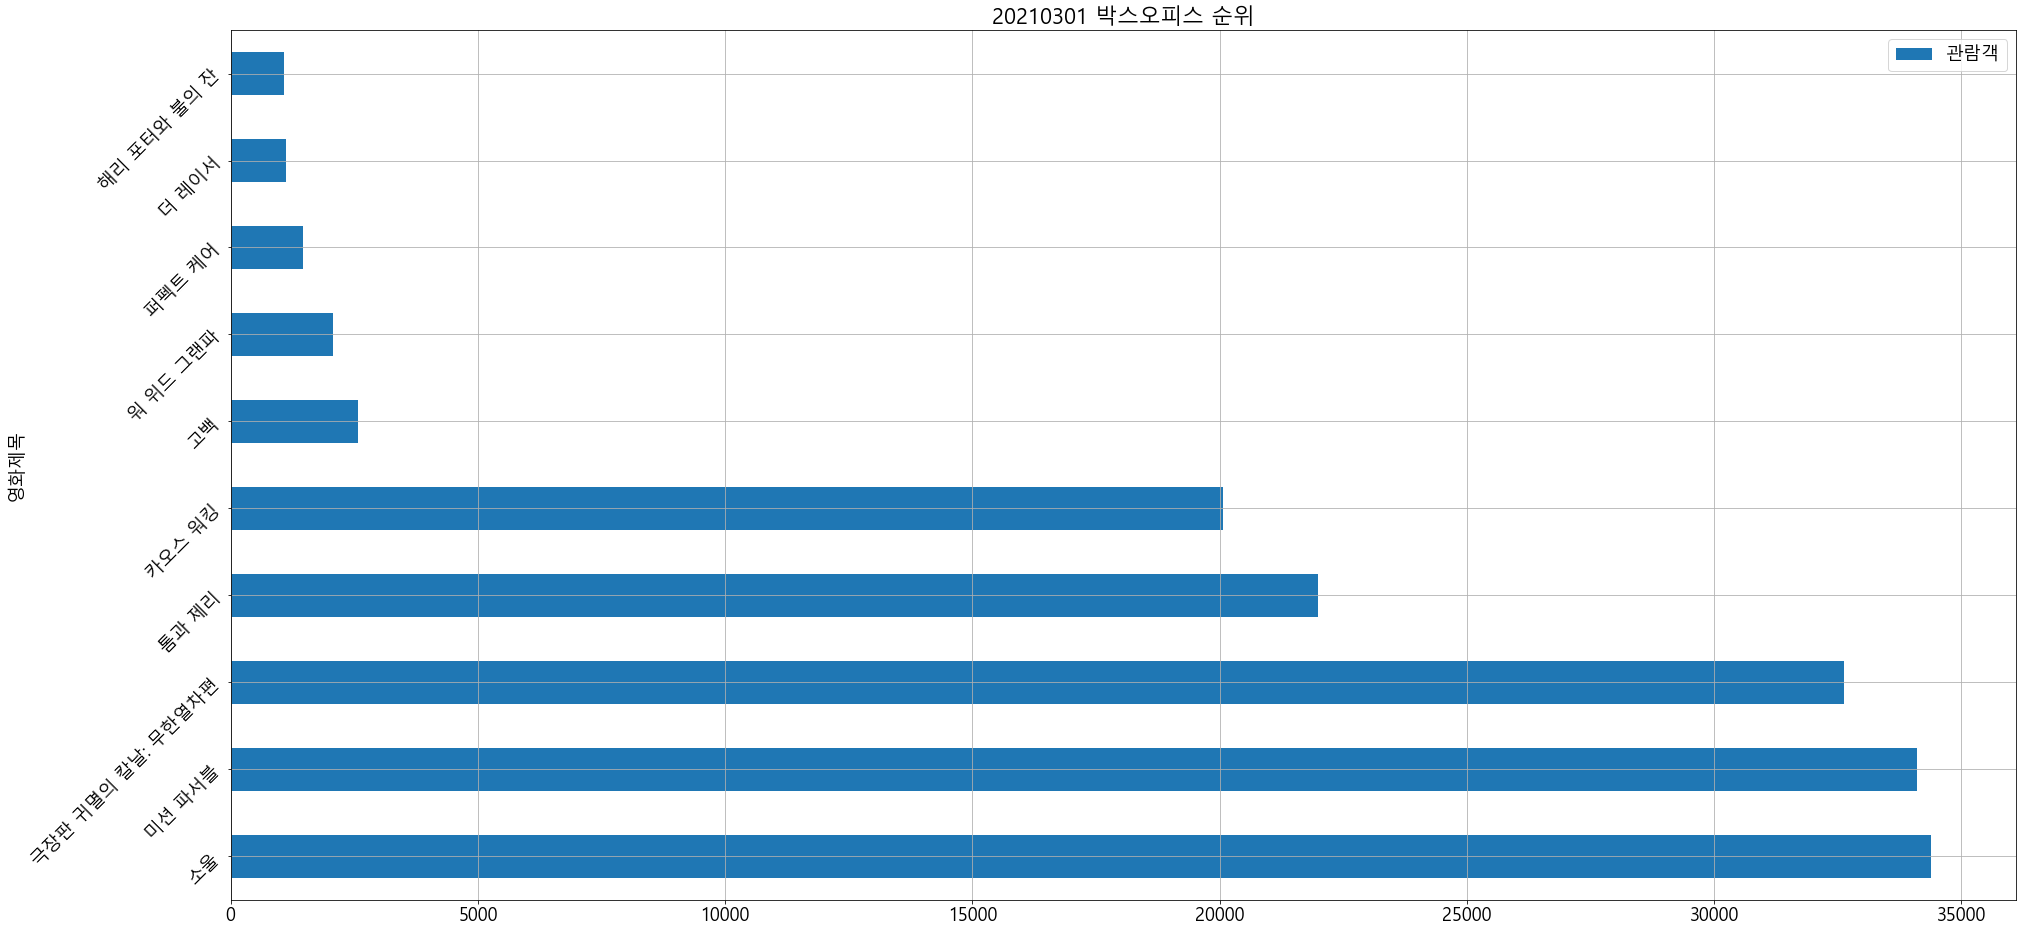

In [21]:
# 그래프를 만들기 위한 한글 폰트 설정
pyplot.rcParams['font.family'] = 'Malgun Gothic'
pyplot.rcParams['font.size'] = 18
pyplot.rcParams['figure.figsize'] = (32, 16)

# 전체 컬럼에 대한 시각화
daily_rank_df.plot.barh(rot=45)
pyplot.grid()
pyplot.title('%s 박스오피스 순위' % yesterday_str)
pyplot.legend()
pyplot.show()
pyplot.close()

# #03. 영화별 1주일 간의 관람객 수 변동 현황
URL에 접속하는 연동 부분을 하나의 블록으로 묶고 날짜를 변경해가며 1주일 간 변화량을 확인

## 1) 반복문을 수행하며 1주일치 데이터 수집하기

In [26]:
# 반복을 수행하며 생성되는 데이터프레임을 누적시킬 빈 데이터 프레임 준비
영화관람객수_df = DataFrame()

# 일주일 간의 기간을 위한 반복문 구성
for i in range(-7, 0):
    
    ### 조회날짜 문자열 만들기
    today = dt.datetime.now()
    delta = dt.timedelta(days=i)
    yesterday = today+delta
    yesterday_str = yesterday.strftime("%Y%m%d")
    #print(yesterday_str)
    
    ### 최종 접속 주소 확인
    api_url = url_tpl.format(key=api_key, date=yesterday_str)
    #print(api_url)
    
    ### API를 통한 JSON 데이터 가져오기
    r = session.get(api_url)

    if r.status_code != 200:
        print("[%d Error] %s" % (r.status_code, r.reason))
        # 특정 주소에 대해 에러가 발생하더라도 다른 주소에 대한 수집을 시도하기 위해 반복을 계속 수행
        continue    

    r.encoding = 'utf-8'
    #print(r.text)
    
    ### 데이터 프레임으로 변환
    daily_boxoffice_dict = json.loads(r.text)
    daily_boxoffice_df = DataFrame(daily_boxoffice_dict['boxOfficeResult']['dailyBoxOfficeList'])
    #print(daily_boxoffice_df)
    
    ### 사용할 컬럼만 추출
    tmp_df = daily_boxoffice_df.filter(['movieNm', 'audiCnt'])
    #print(tmp_df)
    
    ### 컬럼이름 변경 --> 관람객 수를 의미하는 컬럼을 해당 날짜로 변경한다.
    tmp_df2 = tmp_df.rename(columns={'movieNm':'영화제목', 'audiCnt':yesterday_str})
    
    ### 영화제목을 인덱스로 지정
    daily_rank_df = tmp_df2.set_index('영화제목')
    
    ### 관람색 컬럼의 타입을 숫자형식으로 변환
    daily_rank_df[yesterday_str] = daily_rank_df[yesterday_str].apply(pd.to_numeric)
    
    ### 영화이름(daily_rank_df의 인덱스)이 동일한 데이터를 기준으로 누적
    ### how값을 outer로 지정 -> 중복되지 않는 인덱스명(영화제목)도 누락되지 않도록 한다.
    영화관람객수_df = pd.merge(영화관람객수_df, daily_rank_df, left_index=True, right_index=True, how="outer")
                         

####### 최종결과 출력
영화관람객수_df

,20210223,20210224,20210225,20210226,20210227,20210228,20210301
영화제목,,,,,,,
고백,NaN,5401.0,2886.0,2447.0,3819.0,4259.0,2574.0
극장판 귀멸의 칼날: 무한열차편,14662.0,14267.0,18121.0,17532.0,30083.0,35762.0,32618.0
극장판 페이트/그랜드 오더 신성원탁영역 카멜롯 완더링; 아가트람,NaN,NaN,1869.0,NaN,NaN,NaN,NaN
더 레이서,NaN,1294.0,1478.0,1310.0,NaN,NaN,1123.0
더블패티,843.0,NaN,NaN,NaN,NaN,NaN,NaN
라스트 레터,NaN,1506.0,NaN,871.0,1315.0,1347.0,NaN
몬스터 헌터,728.0,NaN,NaN,NaN,NaN,NaN,NaN
미션 파서블,18340.0,17069.0,13255.0,14156.0,30095.0,38772.0,34099.0
빛과 철,692.0,NaN,NaN,NaN,NaN,NaN,NaN


## 2) 데이터 정제
### 결측치 대체
관람객 수가 결측치인 경우 병합 과정에서 해당 날짜에 개봉하지 않은 영화를 의미<br>
결측치인 경우 관람객 수가 0이라는 의미이므로 결측치 대체법 적용

In [27]:
final_df = 영화관람객수_df.fillna(0)
final_df

,20210223,20210224,20210225,20210226,20210227,20210228,20210301
영화제목,,,,,,,
고백,0.0,5401.0,2886.0,2447.0,3819.0,4259.0,2574.0
극장판 귀멸의 칼날: 무한열차편,14662.0,14267.0,18121.0,17532.0,30083.0,35762.0,32618.0
극장판 페이트/그랜드 오더 신성원탁영역 카멜롯 완더링; 아가트람,0.0,0.0,1869.0,0.0,0.0,0.0,0.0
더 레이서,0.0,1294.0,1478.0,1310.0,0.0,0.0,1123.0
더블패티,843.0,0.0,0.0,0.0,0.0,0.0,0.0
라스트 레터,0.0,1506.0,0.0,871.0,1315.0,1347.0,0.0
몬스터 헌터,728.0,0.0,0.0,0.0,0.0,0.0,0.0
미션 파서블,18340.0,17069.0,13255.0,14156.0,30095.0,38772.0,34099.0
빛과 철,692.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3) 데이터 시각화
시간에 따른 데이터의 변화를 표현하기 적합한 형태 = <b>선 그래프(=시계열 그래프)</b>

데이터 프레임을 선 그래프로 표현할 경우 각각의 컬럼이 선으로 표현되고, 인덱스=x축 값=y축으로 사용
> 현재 DataFrame을 바로 시각화할 경우 x축 = 제목, y축 = 날짜별로 하나의 선 -> 맞지 않는 그래프 표현

각각의 영화가 하나의 선이 되고 날짜가x축 관람객 수가 y축이 되도록 하려면 현재 데이터 프레임의 컬럼과 인덱스를 맞바꾼 형태인 전치를 통해 그래프를 표현해야 한다.

### 데이터프레임의 전치 확인

In [28]:
전치데이터 = final_df.T
전치데이터

영화제목,고백,극장판 귀멸의 칼날: 무한열차편,극장판 페이트/그랜드 오더 신성원탁영역 카멜롯 완더링; 아가트람,더 레이서,더블패티,라스트 레터,몬스터 헌터,미션 파서블,빛과 철,새해전야,소울,아이,워 위드 그랜파,카오스 워킹,톰과 제리,퍼펙트 케어,해리 포터와 불의 잔
20210223,0.0,14662.0,0.0,0.0,843.0,0.0,728.0,18340.0,692.0,1363.0,14143.0,772.0,0.0,0.0,0.0,2376.0,1835.0
20210224,5401.0,14267.0,0.0,1294.0,0.0,1506.0,0.0,17069.0,0.0,0.0,14050.0,0.0,2111.0,22422.0,22099.0,1119.0,0.0
20210225,2886.0,18121.0,1869.0,1478.0,0.0,0.0,0.0,13255.0,0.0,0.0,11573.0,0.0,1546.0,12715.0,11103.0,1080.0,0.0
20210226,2447.0,17532.0,0.0,1310.0,0.0,871.0,0.0,14156.0,0.0,0.0,13407.0,0.0,1584.0,13333.0,11144.0,0.0,785.0
20210227,3819.0,30083.0,0.0,0.0,0.0,1315.0,0.0,30095.0,0.0,0.0,29004.0,0.0,2072.0,23925.0,23180.0,1286.0,1146.0
20210228,4259.0,35762.0,0.0,0.0,0.0,1347.0,0.0,38772.0,0.0,0.0,35690.0,0.0,2369.0,27332.0,23716.0,1592.0,1290.0
20210301,2574.0,32618.0,0.0,1123.0,0.0,0.0,0.0,34099.0,0.0,0.0,34390.0,0.0,2068.0,20060.0,21987.0,1458.0,1088.0


### 전치를 사용한 그래프

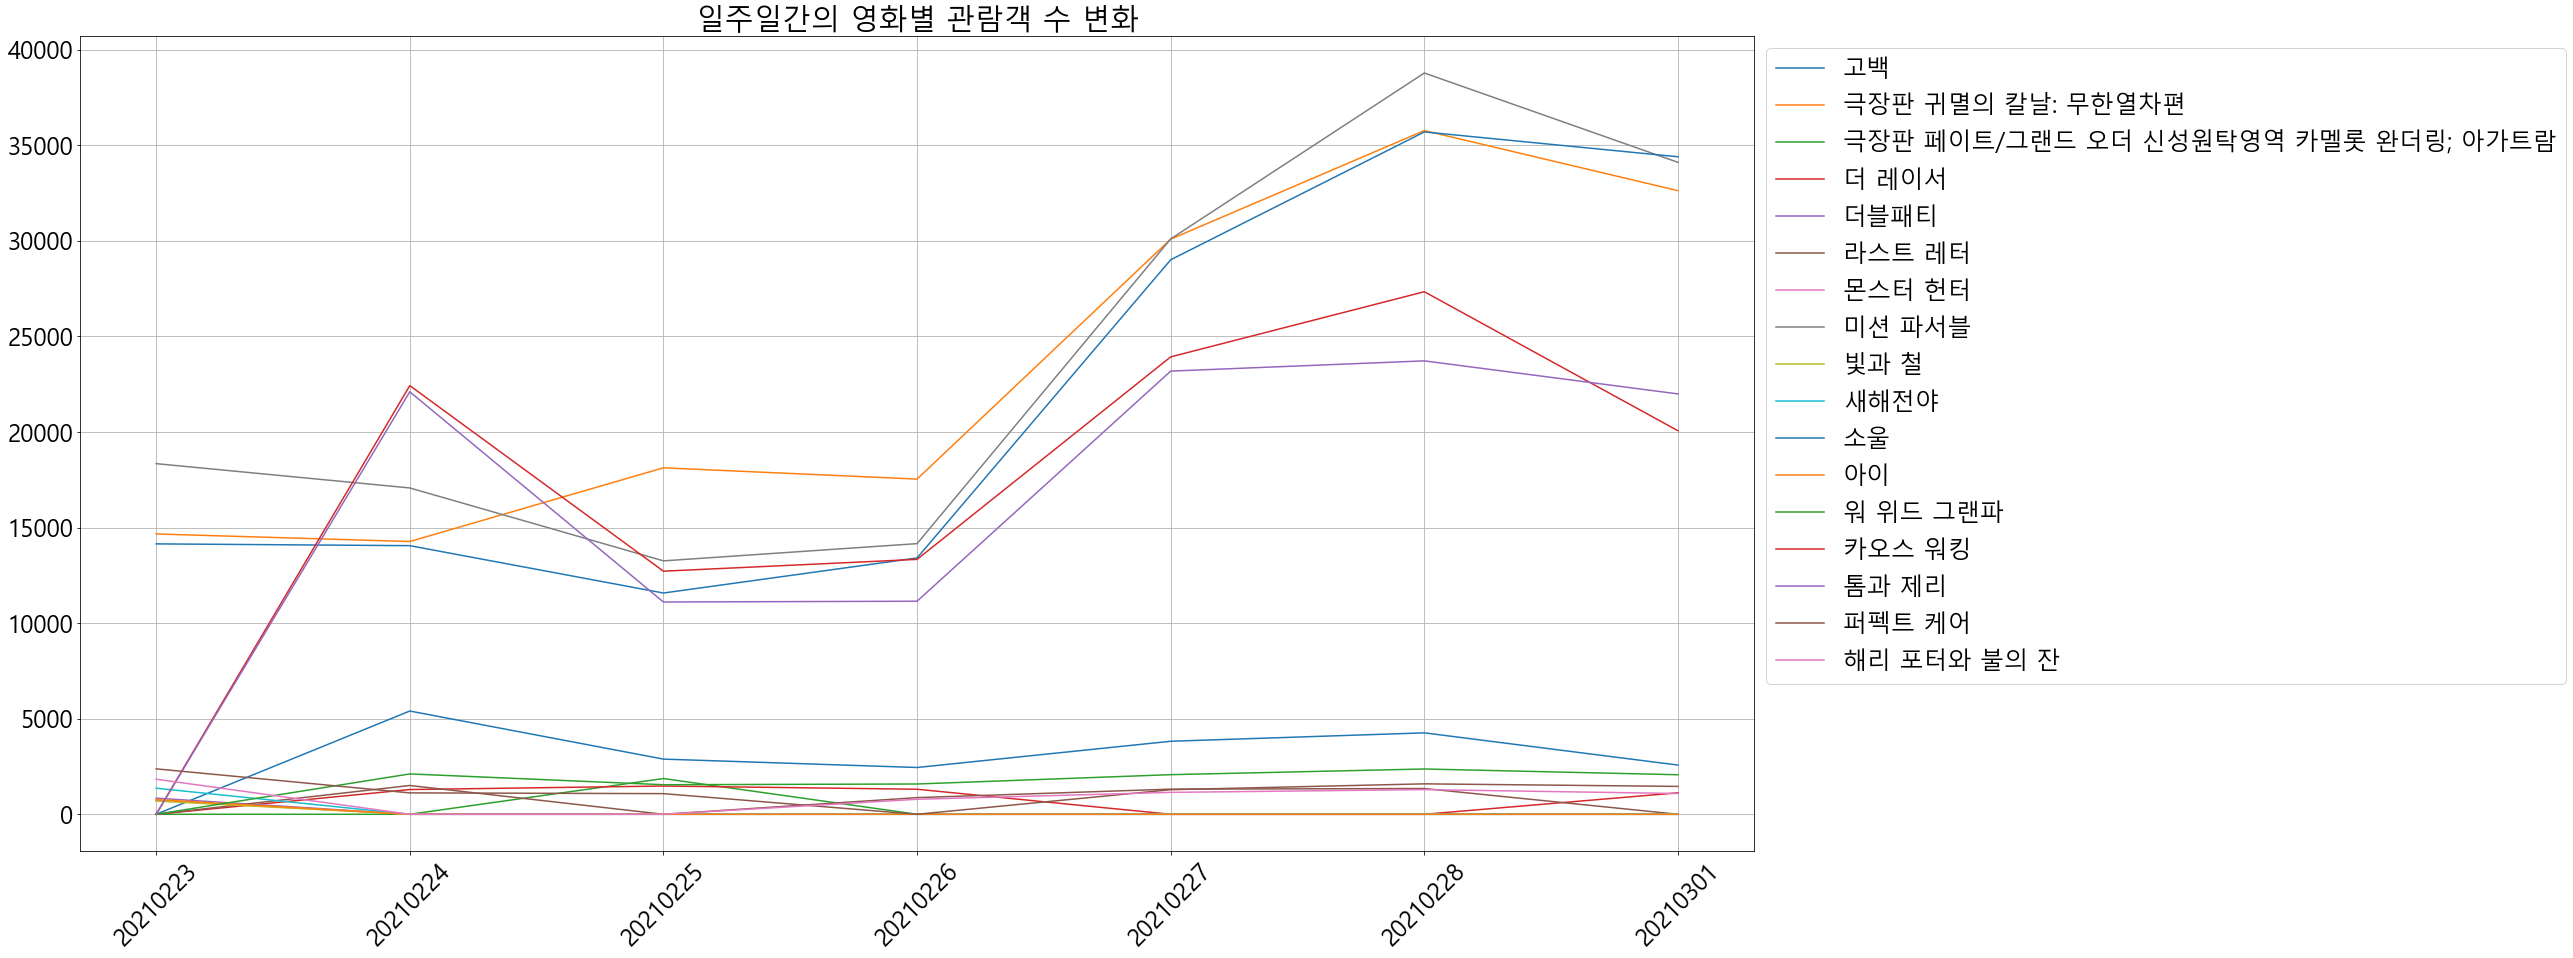

In [29]:
pyplot.rcParams['font.family'] = 'Malgun Gothic'
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['figure.figsize'] = (30, 15)

전치데이터.plot(rot=45)
pyplot.grid()
pyplot.title('일주일간의 영화별 관람객 수 변화')
pyplot.legend(bbox_to_anchor=(1,1))
pyplot.show()
pyplot.close()